In [1]:
import os,sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
from torchvision import datasets, transforms
from core.data import DataGenerator,DatasetsDG
from core.models import SimpleNN,EnsembleModel, SimpleCNN
from core.cf_problem import make_cf_problem
from core.optimization import run_nsga, NSGAConfig
from torch.utils.data import DataLoader, Dataset, TensorDataset
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
from torch import nn

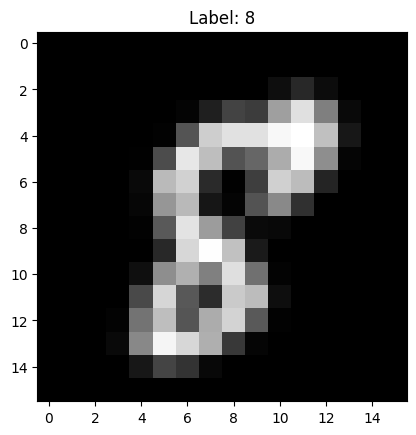

In [2]:
# load dataset and model
# Image size configuration - using 16x16 to reduce search space (256 vs 784 dimensions)
IMG_SIZE = 16

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize from 28x28 to 16x16
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root=os.path.join(root_dir, 'data'), train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=os.path.join(root_dir, 'data'), train=False, download=True, transform=transform)

DG=DatasetsDG(train_dataset, num_classes=10)
models = [SimpleCNN(16,16,input_channels=1, num_classes=10) for _ in range(3)]


# show the first image in the training dataset
image, label = DG.sample(1, seed=44)
plt.imshow(image[0].squeeze(), cmap='gray')
plt.title(f'Label: {label.argmax().item()}')
plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for model in models:
    model.to(device)

criterion = nn.CrossEntropyLoss()

epochs = 50
for model in models:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Create optimizer for each model
    seed = 42 + hash(model) % 1000  # Simple way to get different seeds
    samples = DG.sample(1000, seed=seed)
    model_train_dataset = TensorDataset(samples[0].to(device), samples[1].to(device))
    train_loader = DataLoader(model_train_dataset, batch_size=32, shuffle=True)  # Create loader inside loop
    model.train()
    bar = tqdm(range(epochs), desc="Training Model", colour="blue", unit="epoch")
    running_loss = 0.0
    for epoch in bar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.argmax(dim=1))  # labels are one-hot from DG.sample()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        bar.set_postfix(loss=running_loss/(epoch+1))

Training Model: 100%|██████████| 50/50 [00:04<00:00, 10.78epoch/s, loss=3.12]

Training Model: 100%|██████████| 50/50 [00:04<00:00, 11.26epoch/s, loss=3.23]

Training Model: 100%|██████████| 50/50 [00:04<00:00, 10.95epoch/s, loss=2.83]


(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 tensor([8], device='cuda:0'))

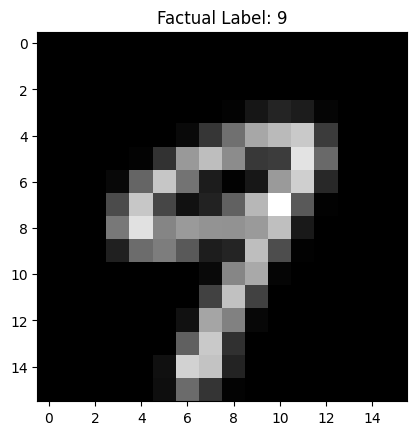

In [7]:
x_factual, y_factual = DG.sample(1, seed=1234)
plt.imshow(x_factual[0].squeeze(), cmap='gray')
plt.title(f'Factual Label: {y_factual.argmax().item()}')
target_class = 8  # Target class different from factual
target_class_tensor = torch.tensor([target_class], device=device)

problem = make_cf_problem(models[0], x_factual, target_class_tensor, DG.sample(1000, seed=5678)[0],device=device)
y_factual,target_class_tensor

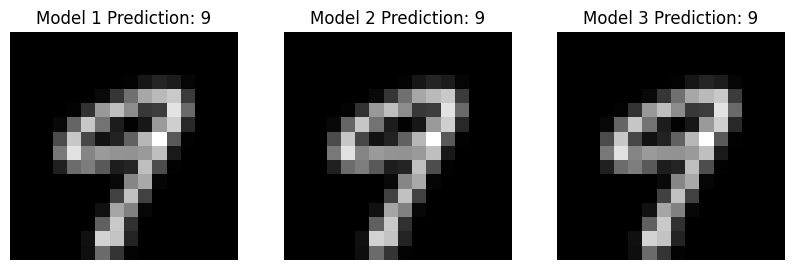

In [10]:
# visualize the each model's prediction on the factual instance using plt
plt.figure(figsize=(10, 4))
for i, model in enumerate(models):
    model.eval()
    with torch.no_grad():
        output = model(x_factual.to(device))
        predicted_class = output.argmax(dim=1).item()
    plt.subplot(1, len(models), i + 1)
    plt.imshow(x_factual[0].squeeze(), cmap='gray')
    plt.title(f'Model {i+1} Prediction: {predicted_class}')
    plt.axis('off')

In [8]:
NSGA2_config = NSGAConfig(
    pop_size=200,
    min_valid_cf=50,
    max_gen=100)
results = run_nsga(problem, NSGA2_config)
    

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     14 |             - |             -
Gen    1 | Valid CFs (pop): 187 | Valid CFs (archive):  14 | Best P(target): 1.000 | Mean Sparsity: 0.391
     2 |      400 |     17 |  0.1428571429 |         nadir
     2 |      400 |     17 |  0.1428571429 |         nadir
     3 |      600 |     15 |  0.3061135227 |         ideal
     3 |      600 |     15 |  0.3061135227 |         ideal
     4 |      800 |     26 |  0.1469311481 |         ideal
     4 |      800 |     26 |  0.1469311481 |         ideal
     5 |     1000 |     33 |  0.1120266481 |         ideal
     5 |     1000 |     33 |  0.1120266481 |         ideal
     6 |     1200 |     33 |  0.1379310345 |         ideal
     6 |     1200 |     33 |  0.1379310345 |         ideal
     7 |     1400 |     33 |  0.0588235294 |         ideal
     7 |     1400 |     33 |  0.0588235294 |         ideal
     8 |     1600 |     37 |  0.0613928287 |         ideal
     8 | 

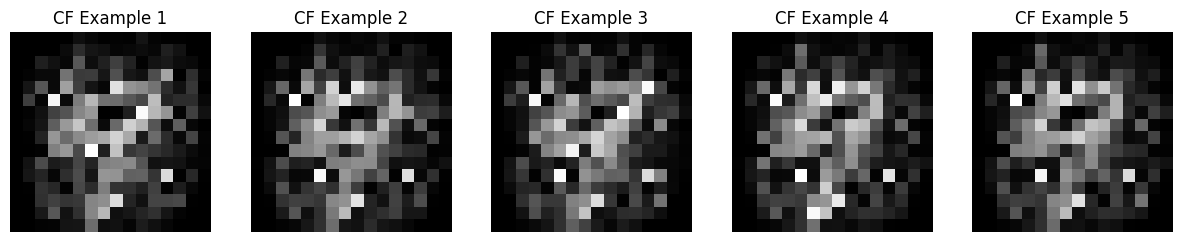

In [14]:
# visualize some counterfactual examples
import numpy as np
num_to_display = 5
fig, axes = plt.subplots(1, num_to_display, figsize=(15, 3))

sorted_indices = np.argsort(results.F[:, 3])  # Sort by first objective (e.g., distance)
selected_indices = sorted_indices[:num_to_display]

for i in range(num_to_display):
    cf_example = results.X[selected_indices[i]].reshape(IMG_SIZE, IMG_SIZE)
    axes[i].imshow(cf_example, cmap='gray')
    axes[i].set_title(f'CF Example {i+1}')
    axes[i].axis('off')